In [22]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [23]:
from scipy.interpolate import interp1d, interp2d

## Making velocity models

* funcs for making synthetic velocity models

In [24]:
def make_surfaces_v1(n_surfaces, n_axis_points, shape=(100, 100, 400),
                     kind='cubic', epsilon_share=0.25, shares=None):
    """ First param is n_surfaces while the second controls how volatile is the curve. Might wanna
    try changing the parameter with curve.
    """
    # make an array of curve-supports
    grid_x = np.linspace(0, 1, n_axis_points)
    grid_y = np.linspace(0, 1, n_axis_points)

    #make the first curve
    curves = [np.zeros((n_axis_points, n_axis_points))]
    shares = shares if shares is not None else np.ones((n_surfaces, ))
    shares = np.array(shares) / np.sum(shares)
    for i in range(n_surfaces):
        delta_h = shares[i]
        epsilon = epsilon_share * delta_h

        # make each curve in unit-terms then scale it to cube-shape
        curves.append(curves[-1] + delta_h * np.ones_like(curves[0])
                      + np.random.uniform(low=-epsilon, high=epsilon, size=curves[0].shape))

    # make an array of interpolations
    funcs = []
    for curve in curves:
        funcs.append(interp2d(grid_x, grid_y, curve, kind=kind))

    # compute in integers
    results = []
    for func in funcs:
        results.append((func(np.arange(shape[1]) / shape[1],
                             np.arange(shape[0]) / shape[0]) * shape[2]).astype(np.int))

    return results

* make and plot curves separating different constant velocity-domains

In [25]:
# уменьшить разброс

In [26]:
shape = (50, 400, 800) # now it's [n_traces X n_samples]
n_colors = 200
low, high = 0.3, 1.8
llim = (high - low) / n_colors
colors = np.linspace(low, high, n_colors) + np.random.uniform(low=-llim, high=llim, size=(n_colors, ))

* add a couple of sharp boundaries

In [27]:
colors[colors.shape[0] // 2:] += llim * 7
colors[2 * colors.shape[0] // 3:] += llim * 5
colors[colors.shape[0] // 4:] -= llim*4

(0, 2)

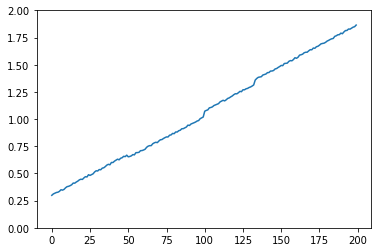

In [28]:
plt.plot(colors)
plt.ylim(0, 2)

In [79]:
shape

(50, 400, 800)

In [30]:
n_points = 10
curves = make_surfaces_v1(n_colors, n_points, epsilon_share=.2, shape=shape)

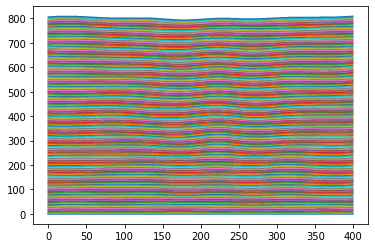

In [31]:
for curve in curves:
    plt.plot(np.arange(shape[1]), curve[30])

In [32]:
curves[0].shape

(50, 400)

* assemble and show velocity-model

In [33]:
n_colors

200

In [34]:
vm = np.zeros(shape=shape)
for i in range(vm.shape[0]):
    for x in range(vm.shape[1]):
        trace = vm[i, x, :]
        for j in range(n_colors):
            low = np.minimum(curves[j][i, x], vm.shape[-1])
            trace[low : ] = colors[j]
mul = 3000
vm = vm * mul

In [35]:
vm.shape

(50, 400, 800)

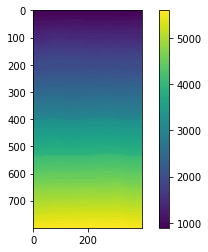

In [36]:
plt.imshow(vm[42].T)
plt.colorbar()

In [37]:
vm.shape

(50, 400, 800)

* make synthetic density logs multiplying synthetic vm on random process

In [38]:
l, h = 0.95, 1.05
rho_mults = np.random.uniform(low=l, high=h, size=vm.shape)
rho = vm * rho_mults

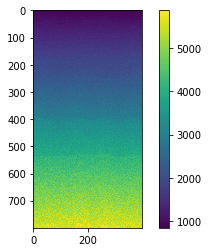

In [39]:
plt.imshow(rho[32].T)
plt.colorbar()

## Making seismic using convolution and velocity models 

In [40]:
def reflectivity(v, rho):
    """ Compute reflectivity coeficcients given velocity and density models.
    """
    rc = np.zeros_like(v)
    rc[..., 1:] = ((v[..., 1:]*rho[..., 1:]-v[..., :-1]*rho[..., :-1]) /
                   (v[..., 1:]*rho[..., 1:]+v[..., :-1]*rho[..., :-1]))
    return rc

In [41]:
def convolutional_model(rc, f, wavelet, dt):
    """ Generate synthetic seismic given reflectivity series and ricker wavelet.
    """
    w = wavelet(f, dt)
    # convolution
    synth_l = np.zeros_like(rc)
    for i in range(rc.shape[0]):
        for x in range(rc.shape[1]):
            if rc.shape[0] >= len(w):
                synth_l[i, x, :] = np.convolve(rc[i, x, :], w, mode='same')
            else:
                aux = np.int(len(w) / 2.0)
                synth_l[i, x, :] = np.convolve(rc[i, x, :], w, mode='full')[aux:-aux]
    return synth_l


In [42]:
def rickerwave(f, dt):
    """ Generate RickerWave given frequency and time-sample rate.
    """
    assert f < 0.2*(1./(2.*dt)), "Frequency too high for the dt chosen."
    nw = 2.2/f/dt
    nw = 2*int(np.floor(nw/2)) + 1
    nc = int(np.floor(nw/2))
    ricker = np.zeros(nw)
    k = np.arange(1, nw+1)
    alpha = (nc-k+1)*f*dt*np.pi
    beta = alpha**2
    
    ricker = (1.-beta*2)*np.exp(-beta)
    return ricker

In [43]:
dt = 0.002

In [44]:
rc = reflectivity(vm, rho)
synt = convolutional_model(rc, 30, rickerwave, dt=dt/3)

In [45]:
synt.shape

(50, 400, 800)

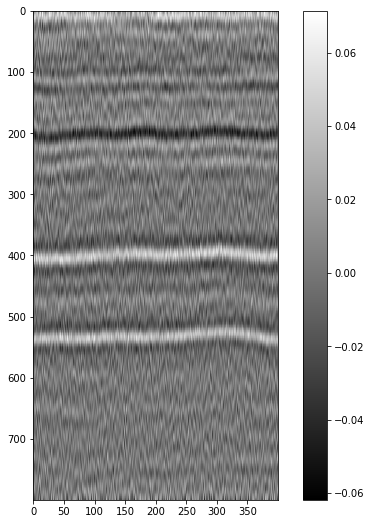

In [46]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.imshow(synt[11].T, cmap=plt.cm.gray)
plt.colorbar()

* apply blur

In [47]:
from scipy.ndimage import gaussian_filter
blurred = gaussian_filter(synt, sigma=1.1)

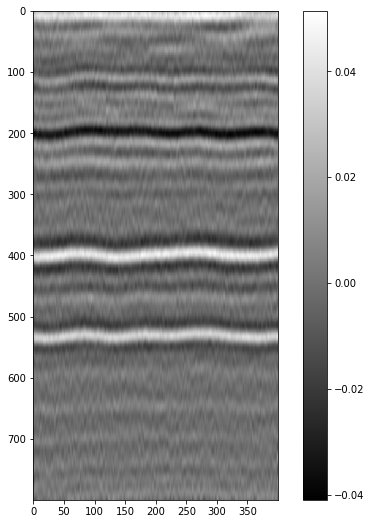

In [48]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.imshow(blurred[41].T, cmap=plt.cm.gray)
plt.colorbar()

* apply noise

In [49]:
noised = blurred + .7* np.random.random(blurred.shape) * blurred.std()

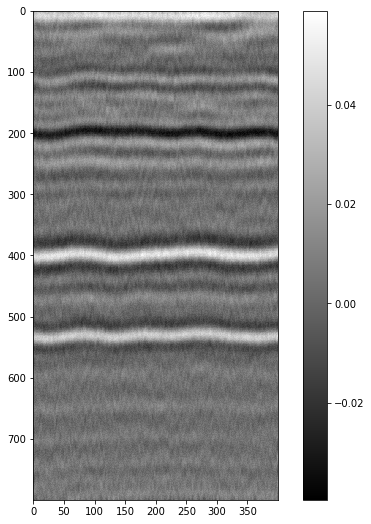

In [50]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.imshow(noised[41].T, cmap=plt.cm.gray)
plt.colorbar()

* all of them

Text(0.5, 1.0, 'Blurred + Noised')

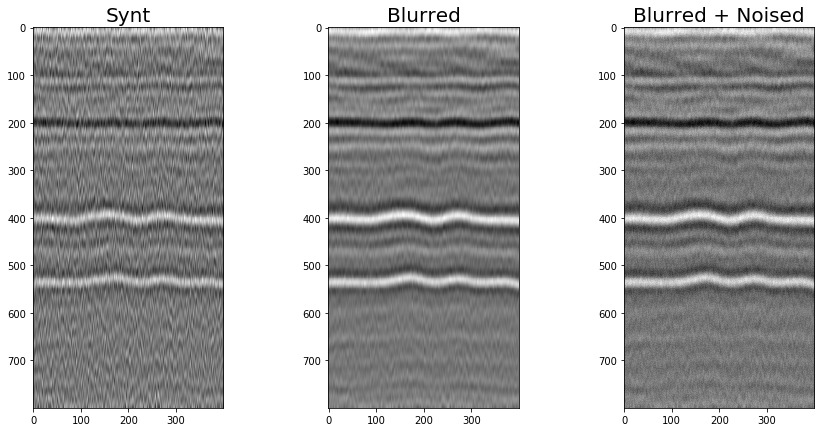

In [51]:
num = 30
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].imshow(synt[num].T, cmap=plt.cm.gray)
axes[1].imshow(blurred[num].T, cmap=plt.cm.gray)
axes[2].imshow(noised[num].T, cmap=plt.cm.gray)
axes[0].set_title('Synt', fontsize=20)
axes[1].set_title('Blurred', fontsize=20)
axes[2].set_title('Blurred + Noised', fontsize=20)

Text(0.5, 1.0, 'Density "logs"')

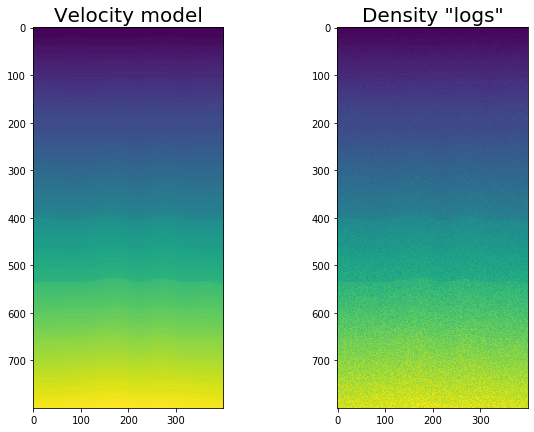

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].imshow(vm[num].T)
axes[1].imshow(rho[num].T)
axes[0].set_title('Velocity model', fontsize=20)
axes[1].set_title('Density "logs"', fontsize=20)